# Classification with CNNs and the CIFAR10 Dataset
We will now apply convolution and pooling layers combined with fully connected layers to classify images from the CIFAR10 dataset. CIFAR10 contains images in the RGB space that have dimensions of 32x32 pixels. Each image falls into 1 of 10 classes: planes, cars, birds, cats, deer, dogs, frogs, horses, ships and trucks. There are 6000 images in each class for a total of 60,000 images.

Researching model architecture, I found an example in the Keras documentation that uses 4 `Conv2d` layers, 4 `MaxPool2d` layers, one hidden fully connected layer with 512 nodes and a final output layer utilizing softmax. 

The goal of this notebook is to implement the same network architecture found in the Keras documentation and apply it using PyTorch.

In [1]:
import torch
import torch.nn.functional as F
from torch import optim, nn
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

import cv2

Let's define some transforms and get our datasets downloaded and into `DataLoader`s. 

Note the order of the transforms in the composition `augment`. While PyTorch docs say that all of these transforms can act on both PIL and Torch image tensors, they work best on PIL images, and can throw errors when acting on Torch image tensors that have not gone through some extra pre-processing. 

In [2]:

augment = transforms.Compose([transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5),
                                                   (0.5, 0.5, 0.5))])

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5),
                                                   (0.5, 0.5, 0.5))])


In [3]:
trainset = datasets.CIFAR10('./data/cifar10/', download=True, train=True, transform=augment)
testset = datasets.CIFAR10('./data/cifar10/', download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainload = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
testload = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=4)

Let's take a look at our first batch, ensuring that everything is loading correctly:

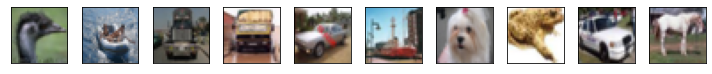

In [5]:
images, labels = iter(trainload).next()

fig, axes = plt.subplots(1, 10, figsize=(10, 15))
for i, im in enumerate(images[:10]):
    im = im.permute(1,2,0) / 2 + 0.5
    axes[i].imshow(im.numpy().squeeze())
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout();

Next, let's set up our our network based on the Keras documentation example:

In [7]:
images[0].shape

torch.Size([3, 32, 32])

In [6]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.fc1   = nn.Linear(64*8*8, 512)
        self.out   = nn.Linear(512, 10)
                
        self.pool  = nn.MaxPool2d(2,2)
        self.drop1 = nn.Dropout(p=0.25)
        self.drop2 = nn.Dropout(p=0.5) 
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.drop1(self.pool(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.drop1(self.pool(x))
        
        x = x.view(-1, 64*8*8)
        x = F.relu(self.fc1(x))
        x = self.out(self.drop2(x))
        return x

## Defining Training Parameters:
__Device:__ First, we set our device in an environment agnostic way. This means that CUDA/GPU will be used automatically if it is detected. Otherwise, training will default to CPU. 

__Loss Function:__ We will use Cross Entropy Loss as our criterion, which according to PyTorch docs:

_"This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class."_ 

This means that the final output layer should only give us raw scores, i.e. the linear combination of inputs without any activation such as ReLU or SoftMax being applied. An activation will be applied within the loss function itself, as alluded to in the docs. 

__Optimizer:__ We will try out a few optimizers and save the results of each for later comparison:

1. SGD  - 60 epochs, lr=0.01, saved model: 'model1.pt'
2. Adam - 60 epochs, lr=0.001, saved model: 'model2.pt'

The learning rates chosen are simply the most common learning rates seen for these two optimizers based on a quick search through documented examples. 

In [7]:
convnet = Network()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 60
lr = 0.001
opt = optim.Adam(convnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [8]:
valid_loss = []
train_loss = []
accuracy   = []

min_valid_loss = np.Inf

convnet = convnet.to(device)

for e in range(epochs):
    running_tl = 0
    running_vl = 0
    running_ac = 0
    
    for images, labels in trainload:
        images, labels = images.to(device), labels.to(device)
        opt.zero_grad()
        scores = convnet(images)
        t_loss = criterion(scores, labels)
        t_loss.backward()
        opt.step()
        running_tl += t_loss.item()
        
    with torch.no_grad():
        convnet.eval()
        for images, labels in testload:
            images, labels = images.to(device), labels.to(device)
            scores = convnet(images)
            v_loss = criterion(scores, labels)
            ps = F.log_softmax(scores, dim=1)
            pred = torch.argmax(ps, dim=1)
            running_vl += v_loss.item()
            running_ac += (pred == labels).cpu().numpy().mean()
        convnet.train()
    
    valid_loss.append(running_vl/len(testload))
    train_loss.append(running_tl/len(trainload))
    accuracy.append(running_ac/len(testload))
    
    # save validation loss when minimum is broken
    if running_vl < min_valid_loss:
        print(f'---------epoch {e}---------')
        print(f'New Minimum Validation Loss: {running_vl:.6f}')
        print('Saving model...')
        torch.save(convnet.state_dict(), 'model2.pt')
        min_valid_loss = running_vl

---------epoch 0---------
New Minimum Validation Loss: 344.557602
Saving model...
---------epoch 1---------
New Minimum Validation Loss: 272.329074
Saving model...
---------epoch 2---------
New Minimum Validation Loss: 248.607174
Saving model...
---------epoch 3---------
New Minimum Validation Loss: 228.359074
Saving model...
---------epoch 4---------
New Minimum Validation Loss: 222.099544
Saving model...
---------epoch 5---------
New Minimum Validation Loss: 213.649417
Saving model...
---------epoch 6---------
New Minimum Validation Loss: 203.910892
Saving model...
---------epoch 8---------
New Minimum Validation Loss: 197.410579
Saving model...
---------epoch 10---------
New Minimum Validation Loss: 195.964284
Saving model...
---------epoch 11---------
New Minimum Validation Loss: 195.553663
Saving model...
---------epoch 12---------
New Minimum Validation Loss: 189.114115
Saving model...
---------epoch 15---------
New Minimum Validation Loss: 183.513133
Saving model...
---------epo

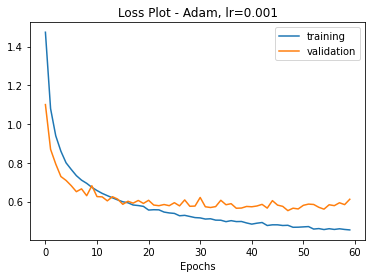

In [9]:
plt.title('Loss Plot - Adam, lr=0.001')
plt.plot(train_loss, label='training')
plt.plot(valid_loss, label='validation')
plt.xlabel('Epochs')
plt.legend()
plt.savefig('loss2.png')

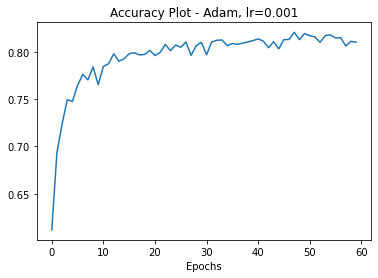

In [11]:
plt.title(f'Accuracy Plot - Adam, lr=0.001')
plt.xlabel('Epochs')
plt.plot(accuracy)
plt.savefig('accuracy2.png')

Now, let's put the see how the two best models perform when put head to head. 

## Stochastic Gradient Descent
Let's look at the average accuracy across all classes over all images in the entire testset:

In [16]:
convnet.load_state_dict(torch.load('model1.pt'))
accuracy = 0
for images, labels in testload:
    images, labels = images.to(device), labels.to(device)
    ps = F.log_softmax(convnet(images), dim=1)
    pred = torch.argmax(ps, dim=1)
    
    # Get average accuracy for each batch
    accuracy += (pred == labels).cpu().numpy().mean()

Drumroll please...

In [17]:
# Average accuracy across all batches
accuracy/len(testload)

0.7759584664536742

## Adam Optimizer
And again, this time for Adam.

In [18]:
convnet.load_state_dict(torch.load('model2.pt'))
accuracy = 0
for images, labels in testload:
    images, labels = images.to(device), labels.to(device)
    ps = F.log_softmax(convnet(images), dim=1)
    pred = torch.argmax(ps, dim=1)
    
    # Get average accuracy for each batch
    accuracy += (pred == labels).cpu().numpy().mean()

accuracy/len(testload)

0.7562899361022364

# Conclusion
After 60 epochs at their respective learning rates, normal SGD outperformed Adam by a whopping 2% in accuracy. 